In [1]:
%load_ext autoreload
%autoreload 2

import pylogics.parsers.ldl
from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic

from stochastic_service_composition.declare_utils import *
from stochastic_service_composition.composition_mdp import composition_mdp
from stochastic_service_composition.composition_mdp import comp_mdp
from stochastic_service_composition.dfa_target import mdp_from_dfa
from stochastic_service_composition.services import build_service_from_transitions, Service
from stochastic_service_composition.target import build_target_from_transitions
from stochastic_service_composition.dfa_target import from_symbolic_automaton_to_declare_automaton

from src.chip.utils import *
import logaut

In [2]:
def target_service_ltlf(declare_constraints, all_symbols_set):
    '''Builds the target service LTLf formula from the DECLARE constraints and symbols.'''
    formula_str = " & ".join(map(lambda s: f"({s})", declare_constraints))
    formula = pylogics.parsers.parse_ltl(formula_str)
    automaton = logaut.core.ltl2dfa(formula, backend="lydia")
    declare_automaton = from_symbolic_automaton_to_declare_automaton(automaton, all_symbols_set)
    return declare_automaton

In [3]:
def build_generic_service_one_state(
    service_name: str,
    operation_names: Set[str],
    action_reward: float,
) -> Service:
    '''1-state service: ready'''
    transitions = {
        "re": {
            operation_name: ({"re": 1.0}, action_reward) for operation_name in operation_names
        },
    }
    final_states = {"re"}
    initial_state = "re"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore


def build_generic_breakable_service(service_name: str, action_name: str, broken_prob: float, broken_reward: float, action_reward: float):
    '''3-states service: available, broken, done'''
    assert 0.0 <= broken_prob <= 1.0
    deterministic_prob = 1.0
    success_prob = deterministic_prob - broken_prob
    transitions = {
        "av": {
            action_name: ({"do": success_prob, "br": broken_prob}, action_reward),
        },
        "br": {
            f"ch_{action_name}": ({"av": 1.0}, broken_reward),
        },
        "do": {
            f"ch_{action_name}": ({"av": 1.0}, 0.0),
        }
    }
    final_states = {"av"}
    initial_state = "av"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore


def build_complex_breakable_service(service_name: str, action_name: str, broken_prob: float, unemployable_prob: float, broken_reward: float, action_reward: float) -> Service:
    '''5-states service: ready, configured, executing, broken, repaired'''
    assert 0.0 <= broken_prob <= 1.0
    deterministic_prob = 1.0
    configure_success_prob = deterministic_prob - unemployable_prob
    op_success_prob = deterministic_prob - broken_prob
    transitions = {
        "re": { # current state
            f"con_{action_name}": # action
                (
                    {
                        "con": deterministic_prob # next state : prob
                    },
                    0.0
                ),
        },
        "con": {
            f"che_{action_name}":
                (
                    {
                    "ex": configure_success_prob,
                    "br": unemployable_prob
                    } if unemployable_prob > 0.0 else {"ex": configure_success_prob},
                    0.0
                ),
        },
        "ex": {
            action_name: # operation
                (
                    {
                        "re": op_success_prob,
                        "br": broken_prob
                    } if broken_prob > 0.0 else {"re": op_success_prob},
                    action_reward
                ),
        },
        "br": {
            f"res_{action_name}":
                (
                    {
                        "rep": deterministic_prob
                    },
                    broken_reward
                ),
        },
        "rep": {
            f"rep_{action_name}":
                (
                    {
                        "re": deterministic_prob
                    },
                    0.0
                ),
        },

    }
    final_states = {"re"}
    initial_state = "re"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

In [4]:
LOW_PROB = 0.05

# probabilities of being broken after an action
DEFAULT_BROKEN_PROB = LOW_PROB
BROKEN_PROB = 0.5
HIGH_BROKEN_PROB = 0.7

# default probability of being unemployable after the configuration
DEFAULT_UNEMPLOYABLE_PROB = LOW_PROB
HIGH_UNEMPLOYABLE_PROB = 0.5

# costs of the machines that perform their job in different countries
DEFAULT_USA_REWARD = -1.0
HIGH_DEFAULT_USA_REWARD = -5.0
UK_REWARD = -6.8
CHINA_REWARD = -11.7
RUSSIA_REWARD = -9.12 
BRAZIL_REWARD = -6.7
BELGIUM_REWARD = -7.6
CANADA_REWARD = -1.8
AUSTRIA_REWARD = -8.38
CHILE_REWARD = -7.8

# default reward when the service becomes broken
DEFAULT_BROKEN_REWARD = -20.0

# actions terms
PROVISIONING = "pro"
MOULDING = "moul"
DRYING = "dry"
FIRST_BAKING = "f_bak"
ENAMELLING = "ena"
PAINT = "paint"
SECOND_BAKING = "s_bak"
SHIPPING = "ship"


ALL_SYMBOLS = [
    PROVISIONING,
    MOULDING,
    DRYING,
    FIRST_BAKING,
    ENAMELLING,
    PAINT,
    SECOND_BAKING,
    SHIPPING
]

ALL_SYMBOLS_SET = set(ALL_SYMBOLS)

# service names
PROVISION1_SERVICE_NAME_USA = "pro1_usa"
MOULD1_SERVICE_NAME_USA = "moul1_usa"
DRYER1_SERVICE_NAME_USA = "dry1_usa"
F_BAKE1_SERVICE_NAME_USA = "f_bak1_usa"
ENAMEL1_SERVICE_NAME_USA = "enam1_usa"
PAINTER1_SERVICE_NAME_USA = "pain1_usa"
S_BAK1_SERVICE_NAME_USA = "s_bak1_usa"
SHIPPING1_SERVICE_NAME_USA = "ship1_usa"

In [5]:
all_services = [
                build_generic_service_one_state(PROVISION1_SERVICE_NAME_USA, {PROVISIONING}, DEFAULT_USA_REWARD),
                build_generic_breakable_service(MOULD1_SERVICE_NAME_USA, MOULDING, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
                build_generic_breakable_service(DRYER1_SERVICE_NAME_USA, DRYING, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
                build_generic_breakable_service(F_BAKE1_SERVICE_NAME_USA, FIRST_BAKING, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
                build_generic_breakable_service(ENAMEL1_SERVICE_NAME_USA, ENAMELLING, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
                build_generic_breakable_service(PAINTER1_SERVICE_NAME_USA, PAINT, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
                build_generic_breakable_service(S_BAK1_SERVICE_NAME_USA, SECOND_BAKING, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
                build_generic_service_one_state(SHIPPING1_SERVICE_NAME_USA, {SHIPPING}, DEFAULT_USA_REWARD),
            ]

## LTLf debug

In [6]:
declare_constraints = [
    exactly_once(PROVISIONING),
    exactly_once(MOULDING),
    exactly_once(DRYING),
    exactly_once(FIRST_BAKING),
    exactly_once(ENAMELLING),
    exactly_once(PAINT),
    exactly_once(SECOND_BAKING),
    exactly_once(SHIPPING),

    alt_succession(PROVISIONING, MOULDING),
    alt_succession(MOULDING, DRYING),
    alt_succession(DRYING, FIRST_BAKING),
    alt_succession(FIRST_BAKING, ENAMELLING),
    alt_succession(ENAMELLING, PAINT),
    alt_succession(PAINT, SECOND_BAKING),
    alt_succession(SECOND_BAKING, SHIPPING),

    build_declare_assumption(ALL_SYMBOLS_SET)
]

In [7]:
declare_automaton = target_service_ltlf(declare_constraints, ALL_SYMBOLS_SET)

Exception: an error occurred while running lydia: [Errno 13] Permission denied: 'lydia'

In [ ]:
render_mdp_dfa(mdp_from_dfa(declare_automaton), no_sink=True)

## Automata

In [12]:
# no loop in the automa
def target_service_automata():
    '''Builds the target service automaton for the given dimension of the problem.'''
    transition_function = {
        "s0": {PROVISIONING: ("s1", 1.0, 0), },
        "s1": {MOULDING: ("s2", 1.0, 0), },
        "s2": {f"ch_{MOULDING}": ("s3", 1.0, 0), },
        "s3": {DRYING: ("s4", 1.0, 0), },
        "s4": {f"ch_{DRYING}": ("s5", 1.0, 0), },
        "s5": {FIRST_BAKING: ("s6", 1.0, 0), },
        "s6": {f"ch_{FIRST_BAKING}": ("s7", 1.0, 0), },
        "s7": {ENAMELLING: ("s8", 1.0, 0), },
        "s8": {f"ch_{ENAMELLING}": ("s9", 1.0, 0), },
        "s9": {PAINT: ("s10", 1.0, 0), },
        "s10": {f"ch_{PAINT}": ("s11", 1.0, 0), },
        "s11": {SECOND_BAKING: ("s12", 1.0, 0), },
        "s12": {f"ch_{SECOND_BAKING}": ("s13", 1.0, 0), },
        "s13": {SHIPPING: ("s14", 1.0, 0.0), },
        "s14": {"no_op": ("s15", 1.0, 0.0), },
    }

    initial_state = "s0"
    final_states = {"s15"}

    return build_target_from_transitions(
        transition_function, initial_state, final_states
    )

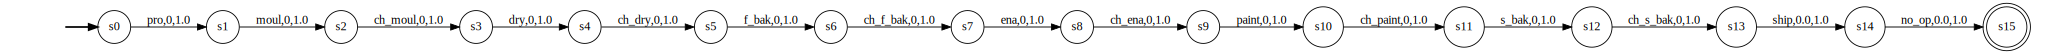

In [13]:
target = target_service_automata()
render_target(target)

In [14]:
gamma = 0.1
mdp = composition_mdp(target, *all_services, gamma=gamma)

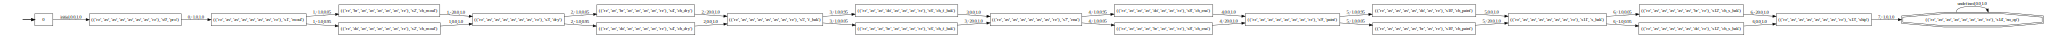

In [15]:
render_composition_mdp(mdp)

In [16]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
opt_policy.policy_data.pop(0, None)

{'initial': 1.0}

In [17]:
print_policy_data(opt_policy)

State=(('re', 'av', 'av', 'av', 'av', 'av', 'av', 're'), 's0', 'pro'),	Action={0: 1.0}
State=(('re', 'av', 'av', 'av', 'av', 'av', 'av', 're'), 's1', 'moul'),	Action={1: 1.0}
State=(('re', 'do', 'av', 'av', 'av', 'av', 'av', 're'), 's2', 'ch_moul'),	Action={1: 1.0}
State=(('re', 'br', 'av', 'av', 'av', 'av', 'av', 're'), 's2', 'ch_moul'),	Action={1: 1.0}
State=(('re', 'av', 'av', 'av', 'av', 'av', 'av', 're'), 's3', 'dry'),	Action={2: 1.0}
State=(('re', 'av', 'do', 'av', 'av', 'av', 'av', 're'), 's4', 'ch_dry'),	Action={2: 1.0}
State=(('re', 'av', 'br', 'av', 'av', 'av', 'av', 're'), 's4', 'ch_dry'),	Action={2: 1.0}
State=(('re', 'av', 'av', 'av', 'av', 'av', 'av', 're'), 's5', 'f_bak'),	Action={3: 1.0}
State=(('re', 'av', 'av', 'do', 'av', 'av', 'av', 're'), 's6', 'ch_f_bak'),	Action={3: 1.0}
State=(('re', 'av', 'av', 'br', 'av', 'av', 'av', 're'), 's6', 'ch_f_bak'),	Action={3: 1.0}
State=(('re', 'av', 'av', 'av', 'av', 'av', 'av', 're'), 's7', 'ena'),	Action={4: 1.0}
State=(('re', 'a